# Import the Libraries

In [241]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure
from skimage import feature

from pandas import read_excel

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score


## HOG Feature Extraction

In [249]:
from IPython.display import clear_output

def get_feature_vector(image_directory, grid_q= 4, orientation= 8, edge= False):
    img= cv2.imread(image_directory, cv2.IMREAD_GRAYSCALE)
    if edge== True:
        img= cv2.Canny(img, 100, 200)

    hog_features = hog(img, orientations= orientation, pixels_per_cell= (int(img.shape[0]/grid_q), int(img.shape[1]/grid_q)), feature_vector= True)

    return hog_features


feature_matrix= []
img_directories= []
for i in range(1, 1300):
    img_dir= "./pictures2/" + str(i) + ".png"
    try:
        feature_vec= get_feature_vector(img_dir, grid_q= 3, orientation= 6, edge= False)
        feature_matrix.append(feature_vec)
        img_directories.append(img_dir)
    except:
        pass

clear_output()
feature_matrix= np.array(feature_matrix)
img_directories= np.array(img_directories)

zero_ratio= np.count_nonzero(feature_matrix)/feature_matrix.size 
print(f"Non-zero feature ratio: {zero_ratio:.3f}", )

Non-zero feature ratio: 0.991


### Scale & PCA

Initial features: 54 Final features: 22


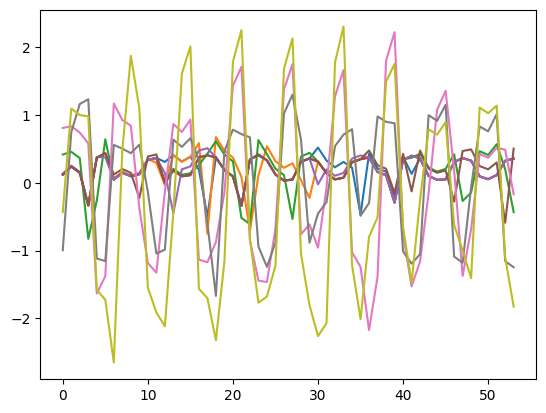

In [243]:
scaler= StandardScaler()
feature_matrix= scaler.fit_transform(feature_matrix)

pca= PCA()
principal_components= pca.fit_transform(feature_matrix)
required_variance= .9
no_components= sum(pca.explained_variance_ratio_.cumsum() < required_variance) + 1

pca_var= PCA(no_components)
principal_matrix= pca_var.fit_transform(feature_matrix)

with open("labels2.csv") as f:
    l= f.read()
    try: # Mac
        int(l[1:2])
        l= l[1:]
    except: # Windows
        l= l[3:]
    
    labels= np.array(l.split(), dtype= int)

labels= labels[0:feature_matrix.shape[0]]

ind= np.logical_or(labels>175, labels<5)
plt.plot(feature_matrix[ind, :].T)


nonzero_index= labels!= 0
labels= labels[nonzero_index]
principal_matrix= principal_matrix[nonzero_index]
print(f"Initial features: {feature_matrix.shape[1]} Final features: {principal_matrix.shape[1]}")


### Support Vector Regressor & Hyperparameter Tuning

In [244]:
X_train, X_test, y_train, y_test, i_train, i_test= train_test_split(principal_matrix, labels, np.arange(labels.size), test_size= .3, random_state= 0)

svr= SVR()

param_grid= [
  {"kernel": ["linear"], "C": [.1, 1, 10, 100]},
  {"kernel": ["rbf"], "C": [1, 10, 100, 500, 1000], "gamma": [1, .1, .01, .001, 0.0001]}
 ]

param_grid= [
  {"kernel": ["rbf"], "C": [100], "gamma": [.01]}
 ]

model= GridSearchCV(svr, param_grid= param_grid, verbose= True)

model.fit(X_train, y_train)
print(model.best_params_)
# print(model.cv_results_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [245]:
y_pred= model.predict(X_test)

mae= mean_absolute_error(y_test, y_pred)

r2= r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae:.3f}")
print(f"R^2 Score: {r2:.3f}")

Mean Absolute Error: 29.522
R^2 Score: 0.294


(0.0, 180.0, 0.0, 180.0)

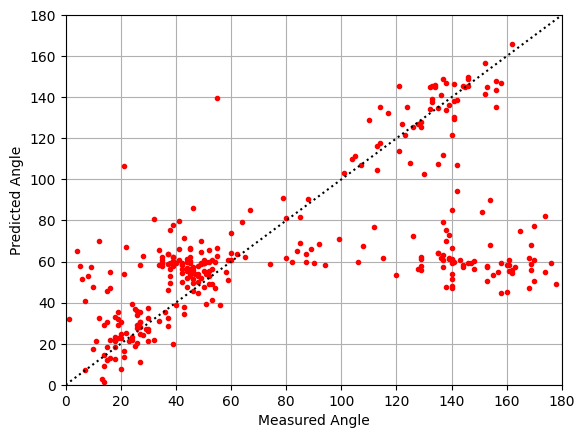

In [246]:
plt.plot(y_test, y_pred, "r.")
plt.plot(np.arange(0, 180), np.arange(0, 180), "k:")
plt.grid()
plt.xlabel("Measured Angle")
plt.ylabel("Predicted Angle")
plt.axis([0, 180, 0, 180])

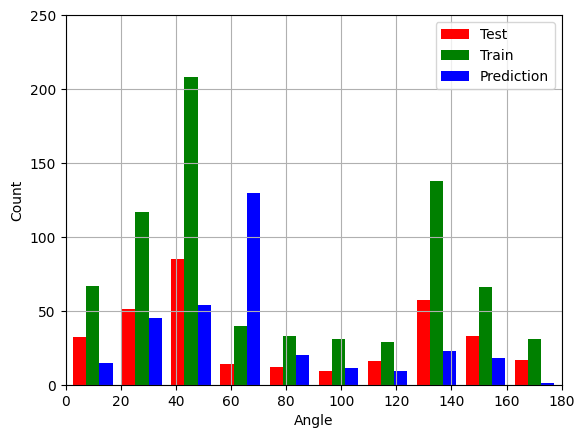

In [247]:
plt.hist([y_test, y_train, y_pred], color= ["r", "g", "b"])
plt.grid()
plt.ylabel("Count")
plt.xlabel("Angle")
plt.axis([0, 180, 0, 250])
plt.legend(["Test", "Train", "Prediction"])

128.95449064292183
Max error at i= 500, measured: 178, predicted: 49.05, error= 128.95


49.04550935707819

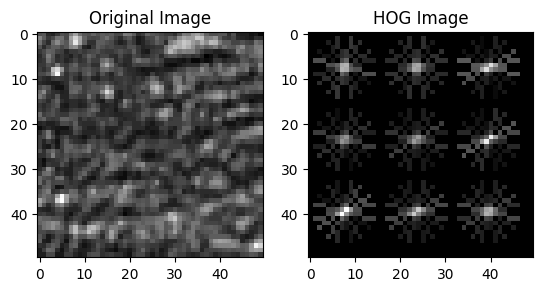

In [251]:
y_error= abs(y_pred-y_test)
y_error_sorted= np.sort(y_error)[::-1]
print(y_error_sorted[0])
i_max_error= np.where(y_error== y_error_sorted[0])[0]
i_abs= i_test[i_max_error][0]

print(f"Max error at i= {i_abs}, measured: {y_test[i_max_error][0]}, predicted: {y_pred[i_max_error][0]:.2f}, error= {y_error_sorted[0]:.2f}")

img_dir= img_directories[i_abs]
img= cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)

hog_features, hog_image = hog(img, orientations= 8, pixels_per_cell= (int(img.shape[0]/3), int(img.shape[1]/3)),
                    visualize=True, feature_vector= True)


plt.subplot(121)
plt.imshow(img, cmap= "gray")
plt.title("Original Image")

plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Image")
y_pred[i_max_error][0]